# Introduction
- nb20 でやったコードの編集バージョン
- 編集項目
    - reduce_mem_
    - typeごと学習

# Import everything I nead :)

In [1]:
import time
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
# from fastprogress import progress_bar

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Preparation

In [2]:
nb = 23
isSmallSet = False
step = 1000

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
file_path = './input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['./input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 './input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 './input/champs-scalar-coupling/structures.csv',
 './input/champs-scalar-coupling/test.csv',
 './input/champs-scalar-coupling/dipole_moments.csv',
 './input/champs-scalar-coupling/potential_energy.csv',
 './input/champs-scalar-coupling/sample_submission.csv',
 './input/champs-scalar-coupling/train.csv',
 './input/champs-scalar-coupling/mulliken_charges.csv']

In [5]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [::step]
else:
    train = pd.read_csv(path)

In [6]:
# test
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path)[::step]
else:
    test = pd.read_csv(path)

In [7]:
# structure
path = file_path + 'structures.csv'
structures = pd.read_csv(path)

In [8]:
# scalar coupling contributions
path = file_path + 'scalar_coupling_contributions.csv'
if isSmallSet:
    contrib = pd.read_csv(path)[::step]
else:
    contrib = pd.read_csv(path)

In [9]:
if isSmallSet:
    print('using SmallSet !!')
    print('-------------------')

print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 29 unique atoms.
There are 8 unique types.


---
**metrics**

In [10]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

---
**momory**

In [11]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Feature Engineering

**basic**

In [12]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

distances

In [13]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

`type` の特徴量から、数字を抽出  
例) 2JHC ---> 2

In [14]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

---
続いて、**分子単位**の特徴量を抽出する。

In [15]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']

    df = reduce_mem_usage(df)
    return df

In [16]:
%%time
train = create_features(train)

Mem. usage decreased to 826.28 Mb (68.2% reduction)
CPU times: user 40.5 s, sys: 54.4 s, total: 1min 34s
Wall time: 1min 34s


In [17]:
%%time
test = create_features(test)

Mem. usage decreased to 430.10 Mb (68.8% reduction)
CPU times: user 21.5 s, sys: 25 s, total: 46.6 s
Wall time: 46.6 s


In [18]:
# mine
good_columns = [
'atom_1',
'atom_0_couples_count',
'atom_1_couples_count',
'atom_index_0',
'atom_index_1',
'dist',
'molecule_atom_1_dist_mean',
'molecule_atom_1_dist_min',
'molecule_atom_1_dist_min_diff',
'molecule_atom_1_dist_min_div',
'molecule_atom_1_dist_std',
'molecule_atom_1_dist_std_diff',
'molecule_atom_index_0_dist_max',
'molecule_atom_index_0_dist_max_diff',
'molecule_atom_index_0_dist_max_div',
'molecule_atom_index_0_dist_mean',
'molecule_atom_index_0_dist_mean_diff',
'molecule_atom_index_0_dist_mean_div',
'molecule_atom_index_0_dist_min',
'molecule_atom_index_0_dist_min_diff',
'molecule_atom_index_0_dist_min_div',
'molecule_atom_index_0_dist_std',
'molecule_atom_index_0_dist_std_diff',
'molecule_atom_index_0_dist_std_div',
'molecule_atom_index_0_x_1_std',
'molecule_atom_index_0_y_1_max',
'molecule_atom_index_0_y_1_max_diff',
'molecule_atom_index_0_y_1_mean',
'molecule_atom_index_0_y_1_mean_diff',
'molecule_atom_index_0_y_1_mean_div',
'molecule_atom_index_0_y_1_std',
'molecule_atom_index_0_z_1_std',
'molecule_atom_index_1_dist_max',
'molecule_atom_index_1_dist_max_diff',
'molecule_atom_index_1_dist_max_div',
'molecule_atom_index_1_dist_mean',
'molecule_atom_index_1_dist_mean_diff',
'molecule_atom_index_1_dist_mean_div',
'molecule_atom_index_1_dist_min',
'molecule_atom_index_1_dist_min_diff',
'molecule_atom_index_1_dist_min_div',
'molecule_atom_index_1_dist_std',
'molecule_atom_index_1_dist_std_diff',
'molecule_atom_index_1_dist_std_div',
'molecule_couples',
'molecule_dist_max',
'molecule_dist_mean',
'molecule_dist_min',
'molecule_type_0_dist_std',
'molecule_type_0_dist_std_diff',
'molecule_type_dist_max',
'molecule_type_dist_mean',
'molecule_type_dist_mean_diff',
'molecule_type_dist_mean_div',
'molecule_type_dist_min',
'molecule_type_dist_std',
'molecule_type_dist_std_diff',
'type',
'type_0',
'x_0',
'x_1',
'y_1',
'z_0',
'z_1']

---
LabelEncode
- `atom_1` = {H, C, N}
- `type_0` = {1, 2, 3}
- `type`   = {2JHC, ...}

In [19]:
for f in ['atom_1', 'type_0', 'type']:
    if f in good_columns:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

---
**show features**

In [20]:
train.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,type_0,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff
0,0,dsgdb9nsd_000001,1,0,0,84.812500,H,0.00215,-0.006031,0.001976,0,-0.012695,1.085938,0.008003,1.091797,0.000221,1.192383,0.000036,0,10,1.506836,1.091797,1.783203,4,4,0.728027,1.358398,0.272949,1.251380,1.463867,0.37793,0.182251,0.728027,1.610352,0.518555,1.474609,1.783203,0.691406,1.632812,1.091797,0.000000,1.000000,0.345703,-0.746582,0.316406,1.091797,-0.000003,1.0,1.091797,0.0,1.0,1.091797,-0.000007,1.0,0.000003,-1.091797,0.000003,1.091797,1.091797,-0.000007,1.0,0.000003,-1.091797,0.000003,-1.091797,1.091797,-0.000003,1.0,1.091797,1.091797,0.000003,-1.091797
1,1,dsgdb9nsd_000001,1,2,3,-11.257812,H,0.00215,-0.006031,0.001976,1,1.011719,1.463867,0.000277,1.783203,1.019531,2.160156,0.000003,1,10,1.506836,1.091797,1.783203,4,1,0.728027,1.358398,-0.104980,0.928268,1.463867,0.00000,0.182251,0.728027,1.610352,-0.172729,0.903320,1.783203,0.000037,1.000000,1.091797,-0.691406,0.612305,0.345703,-1.437500,0.193848,1.783203,0.000000,1.0,1.783203,0.0,1.0,1.783203,0.000000,1.0,NaN,NaN,NaN,1.783203,1.783203,0.000000,1.0,0.000014,-1.783203,0.000014,-1.783203,1.783203,0.000027,1.0,1.783203,1.783203,0.000014,-1.783203


In [21]:
print(train.columns)

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'atom_0', 'x_0', 'y_0', 'z_0', 'atom_1',
       'x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z', 'type_0',
       'molecule_couples', 'molecule_dist_mean', 'molecule_dist_min',
       'molecule_dist_max', 'atom_0_couples_count', 'atom_1_couples_count',
       'molecule_atom_index_0_x_1_std', 'molecule_atom_index_0_y_1_mean',
       'molecule_atom_index_0_y_1_mean_diff',
       'molecule_atom_index_0_y_1_mean_div', 'molecule_atom_index_0_y_1_max',
       'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_y_1_std',
       'molecule_atom_index_0_z_1_std', 'molecule_atom_index_0_dist_mean',
       'molecule_atom_index_0_dist_mean_diff',
       'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max',
       'molecule_atom_index_0_dist_max_diff',
       'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min',
       'molecule_atom_index_0

In [22]:
# 選ばなかった特徴量
sorted(list(set(train.columns) - set(good_columns)))

['atom_0',
 'dist_x',
 'dist_y',
 'dist_z',
 'id',
 'molecule_name',
 'scalar_coupling_constant',
 'y_0']

# create train, test data

In [23]:
X = train[good_columns].copy()
y = train['scalar_coupling_constant']
y_fc = contrib['fc'].values
X_test = test[good_columns].copy()

In [24]:
del train, test

In [25]:
gc.collect()

35

# Create New Features
- このノートブックの本題
- 上で作った特徴量を使用して、新しい特徴量を作成する。
- lightGBMを使う。

## train and predict

**params**

In [26]:
# Configuration
TARGET = 'scalar_coupling_constant'
CAT_FEATS = ['type']
N_ESTIMATORS = 3000
VERBOSE = 600
EARLY_STOPPING_ROUNDS = 200
RANDOM_STATE = 529
METRIC = mean_absolute_error

# lightgbm params
lgb_params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }


In [27]:
n_folds = 3
folds = KFold(n_splits=n_folds, shuffle=True)

In [28]:
# init

def train_lgb(X, X_test, y, lgb_params, folds,
              verbose, early_stopping_rounds, n_estimators):

    result_dict = {}
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    models = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
        print('------------------')
        print(f'- fold{fold_n + 1}' )
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        

        # Train the model
        model = lgb.LGBMRegressor(**lgb_params, n_estimators=n_estimators, n_jobs=77)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=verbose,
                  early_stopping_rounds=early_stopping_rounds)

        # predict
        y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration_)   # oof: out of folds
        y_test_pred = model.predict(X_test)

        oof[valid_idx] = y_valid_pred.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_valid_pred))

        prediction += y_test_pred

        # feature_importance
        fold_importance = pd.DataFrame()
        fold_importance['feature'] = X.columns
        fold_importance['importance'] = model.feature_importances_
        fold_importance['fold'] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    # result
    prediction /= folds.n_splits
    feature_importance["importance"] /= folds.n_splits
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['feature_importance'] = feature_importance


    print('------------------')
    print('====== finish ======')
    print('score list:', scores)
    X['scalar_coupling_constant'] = y
    metric = kaggle_metric(X, oof)
#     X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
    print('CV mean score(group log mae): {0:.4f}'.format(metric))

    
    return result_dict

In [29]:
# train
result_dict = train_lgb(X=X, X_test=X_test, y=y_fc, lgb_params=lgb_params, folds=folds,
                        verbose=VERBOSE, early_stopping_rounds=EARLY_STOPPING_ROUNDS, 
                        n_estimators=N_ESTIMATORS)

X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)

------------------
- fold1
Fold 1 started at Tue Jul  2 05:35:25 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 1.07956	valid_1's l1: 1.14501
[1200]	training's l1: 0.945934	valid_1's l1: 1.05482
[1800]	training's l1: 0.86058	valid_1's l1: 1.00574
[2400]	training's l1: 0.79665	valid_1's l1: 0.973898
[3000]	training's l1: 0.744917	valid_1's l1: 0.950435
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.744917	valid_1's l1: 0.950435
------------------
- fold2
Fold 2 started at Tue Jul  2 05:57:09 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 1.08237	valid_1's l1: 1.14872
[1200]	training's l1: 0.946808	valid_1's l1: 1.05749
[1800]	training's l1: 0.860109	valid_1's l1: 1.00698
[2400]	training's l1: 0.797076	valid_1's l1: 0.975471
[3000]	training's l1: 0.746181	valid_1's l1: 0.952735
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.746181	valid_1's l1: 0.952735
--

##  EDA for fc_pred

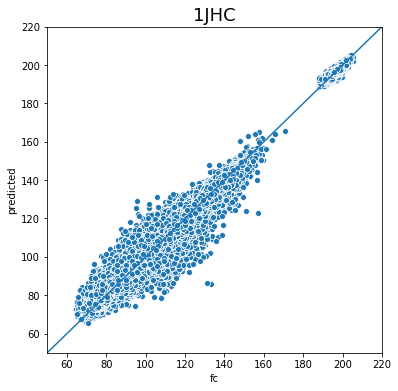

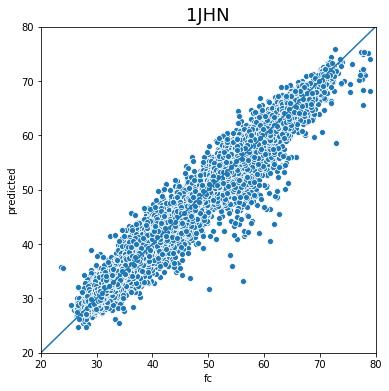

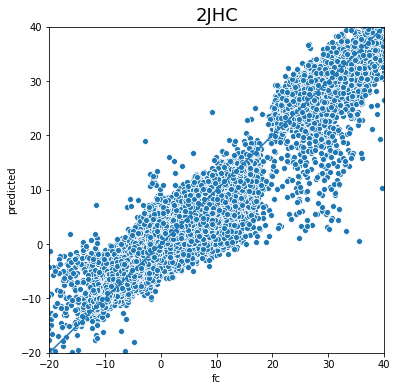

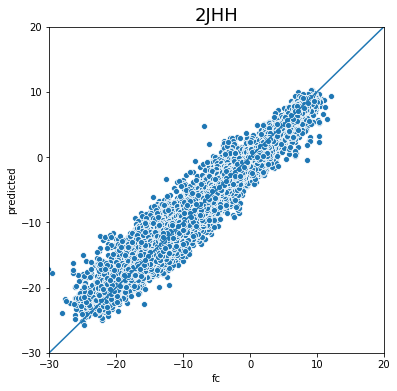

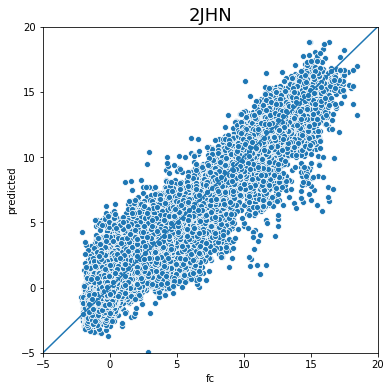

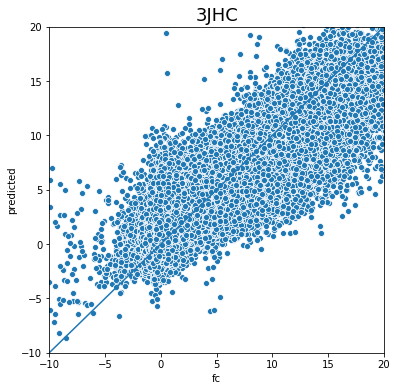

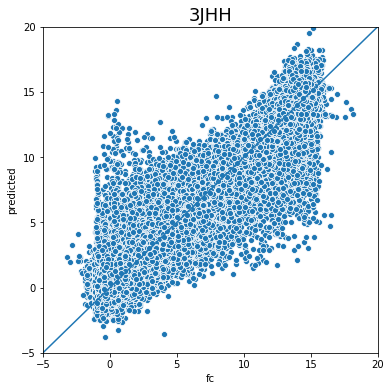

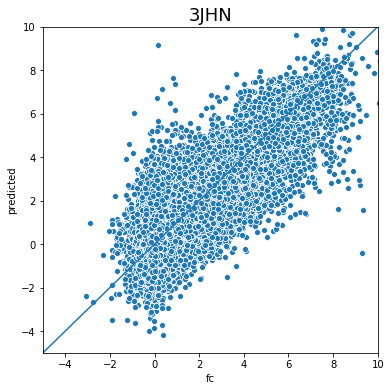

In [30]:
plot_data = pd.DataFrame(y_fc, columns=['fc'])
plot_data.index.name = 'id'
plot_data['yhat'] = result_dict['oof']
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='fc',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['fc', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('fc')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 50, 220)
plot_oof_preds('1JHN', 20, 80)
plot_oof_preds('2JHC', -20, 40)
plot_oof_preds('2JHH', -30, 20)
plot_oof_preds('2JHN', -5, 20)
plot_oof_preds('3JHC', -10, 20)
plot_oof_preds('3JHH', -5, 20)
plot_oof_preds('3JHN', -5, 10)

---> 上図はあくまで、fc を train data で学習してtrain data を予測したに過ぎないことに注意。  
---> 結果としては悪くない  
---> では、train data と、test data にfc を追加しよう。  
---> train data は元データを。test data には、予測データを格納する。

---
**add fc data**

In [31]:
X['fc'] = result_dict['oof']
X_test['fc'] = result_dict['prediction']

In [32]:
print(len(X.columns))
print(len(X_test.columns))

65
65


# Training model
- 上では、test data の 特徴量fc を予測しtest data に追加した。
- 新しいX, X_test を用いて、学習、予測を行う。

**params**

In [33]:
# Configuration
TARGET = 'scalar_coupling_constant'
CAT_FEATS = ['type']
N_ESTIMATORS = 3000
VERBOSE = 600
EARLY_STOPPING_ROUNDS = 200
RANDOM_STATE = 529
METRIC = mean_absolute_error

# lightgbm params
lgb_params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }


In [34]:
# type ごとの学習 

feature_importance  = pd.DataFrame()
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target'].values
#     from IPython.core.debugger import Pdb; Pdb().set_trace()

#     result_dict_lgb3 = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
#                                                       verbose=500, early_stopping_rounds=200, n_estimators=3000)
    result_dict = train_lgb(X=X_t, X_test=X_test_t, y=y_t, folds=folds, lgb_params=lgb_params,
                              verbose=VERBOSE, early_stopping_rounds=EARLY_STOPPING_ROUNDS, n_estimators=N_ESTIMATORS)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict['prediction']
    
    feature_importance = pd.concat([feature_importance, result_dict['feature_importance']], axis=0)
    

print('===== finish =====')
X['scalar_coupling_constant'] = y
metric = kaggle_metric(X, X_short['oof'])
X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
print('CV mean score(group log mae): {0:.4f}'.format(metric))
prediction = X_short_test['prediction']
# X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
# sub['scalar_coupling_constant'] = X_short_test['prediction']
# sub.to_csv('submission_t.csv', index=False)
# sub.head()

Training of type 0
------------------
- fold1
Fold 1 started at Tue Jul  2 06:35:26 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 1.31461	valid_1's l1: 1.67034
[1200]	training's l1: 1.03062	valid_1's l1: 1.62564
[1800]	training's l1: 0.824653	valid_1's l1: 1.59574
[2400]	training's l1: 0.671781	valid_1's l1: 1.5761
[3000]	training's l1: 0.554497	valid_1's l1: 1.56196
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.554497	valid_1's l1: 1.56196


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
- fold2
Fold 2 started at Tue Jul  2 06:38:04 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 1.32125	valid_1's l1: 1.67309
[1200]	training's l1: 1.03299	valid_1's l1: 1.62783
[1800]	training's l1: 0.82665	valid_1's l1: 1.59813
[2400]	training's l1: 0.673789	valid_1's l1: 1.57729
[3000]	training's l1: 0.555915	valid_1's l1: 1.56433
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.555915	valid_1's l1: 1.56433


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
- fold3
Fold 3 started at Tue Jul  2 06:40:37 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 1.31352	valid_1's l1: 1.67552
[1200]	training's l1: 1.02736	valid_1's l1: 1.63189
[1800]	training's l1: 0.822119	valid_1's l1: 1.60375
[2400]	training's l1: 0.670183	valid_1's l1: 1.58408
[3000]	training's l1: 0.554126	valid_1's l1: 1.56956
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.554126	valid_1's l1: 1.56956


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



------------------
====== finish ======
score list: [1.5619643225772533, 1.5643339068795754, 1.5695553515351024]


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



CV mean score(group log mae): 0.4481
Training of type 3
------------------
- fold1
Fold 1 started at Tue Jul  2 06:43:50 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.249584	valid_1's l1: 0.383783
[1200]	training's l1: 0.165128	valid_1's l1: 0.363338
[1800]	training's l1: 0.11813	valid_1's l1: 0.35603
[2400]	training's l1: 0.0869379	valid_1's l1: 0.352521
[3000]	training's l1: 0.065135	valid_1's l1: 0.350477
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.065135	valid_1's l1: 0.350477


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
- fold2
Fold 2 started at Tue Jul  2 06:46:57 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.248945	valid_1's l1: 0.380705
[1200]	training's l1: 0.165356	valid_1's l1: 0.361569
[1800]	training's l1: 0.118289	valid_1's l1: 0.354423
[2400]	training's l1: 0.0869714	valid_1's l1: 0.350792
[3000]	training's l1: 0.0651564	valid_1's l1: 0.348851
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.0651564	valid_1's l1: 0.348851


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
- fold3
Fold 3 started at Tue Jul  2 06:50:00 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.246447	valid_1's l1: 0.381917
[1200]	training's l1: 0.1632	valid_1's l1: 0.361955
[1800]	training's l1: 0.116693	valid_1's l1: 0.354696
[2400]	training's l1: 0.0856934	valid_1's l1: 0.350993
[3000]	training's l1: 0.064493	valid_1's l1: 0.349147
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.064493	valid_1's l1: 0.349147


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



------------------
====== finish ======
score list: [0.35047700941962495, 0.3488514144268715, 0.3491473996097849]


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



CV mean score(group log mae): -1.0513
Training of type 1
------------------
- fold1
Fold 1 started at Tue Jul  2 06:53:16 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.264773	valid_1's l1: 0.862671
[1200]	training's l1: 0.0981513	valid_1's l1: 0.845146
[1800]	training's l1: 0.0390723	valid_1's l1: 0.84038
[2400]	training's l1: 0.0153282	valid_1's l1: 0.838868
[3000]	training's l1: 0.0059843	valid_1's l1: 0.838434
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.0059843	valid_1's l1: 0.838434


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
- fold2
Fold 2 started at Tue Jul  2 06:54:08 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.26057	valid_1's l1: 0.871943
[1200]	training's l1: 0.0960799	valid_1's l1: 0.854449
[1800]	training's l1: 0.0391459	valid_1's l1: 0.850018
[2400]	training's l1: 0.0153802	valid_1's l1: 0.848891
[3000]	training's l1: 0.00614808	valid_1's l1: 0.84844
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.00614808	valid_1's l1: 0.84844


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
- fold3
Fold 3 started at Tue Jul  2 06:55:05 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.256739	valid_1's l1: 0.863529
[1200]	training's l1: 0.0956244	valid_1's l1: 0.846947
[1800]	training's l1: 0.0378143	valid_1's l1: 0.84309
[2400]	training's l1: 0.0146797	valid_1's l1: 0.841952
[3000]	training's l1: 0.00579551	valid_1's l1: 0.841554
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.00579551	valid_1's l1: 0.841554


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
====== finish ======
score list: [0.8384342217072055, 0.8484402004101145, 0.8415541653245445]
CV mean score(group log mae): -0.1710
Training of type 4
------------------
- fold1
Fold 1 started at Tue Jul  2 06:55:55 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.143107	valid_1's l1: 0.389854
[1200]	training's l1: 0.0648641	valid_1's l1: 0.380571
[1800]	training's l1: 0.0320782	valid_1's l1: 0.378052
[2400]	training's l1: 0.016515	valid_1's l1: 0.377048
[3000]	training's l1: 0.0090368	valid_1's l1: 0.376631
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.0090368	valid_1's l1: 0.376631


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
- fold2
Fold 2 started at Tue Jul  2 06:57:01 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.143782	valid_1's l1: 0.391222
[1200]	training's l1: 0.0648982	valid_1's l1: 0.381709
[1800]	training's l1: 0.0323998	valid_1's l1: 0.379375
[2400]	training's l1: 0.0168335	valid_1's l1: 0.378384
[3000]	training's l1: 0.00919147	valid_1's l1: 0.378002
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.00919147	valid_1's l1: 0.378002


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
- fold3
Fold 3 started at Tue Jul  2 06:59:37 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.144875	valid_1's l1: 0.389445
[1200]	training's l1: 0.0653378	valid_1's l1: 0.379672
[1800]	training's l1: 0.032246	valid_1's l1: 0.377171
[2400]	training's l1: 0.0166891	valid_1's l1: 0.376221
[3000]	training's l1: 0.00907315	valid_1's l1: 0.375848
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.00907315	valid_1's l1: 0.375848


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
====== finish ======
score list: [0.37663059223080064, 0.37800229793027035, 0.37584779822897085]
CV mean score(group log mae): -0.9760
Training of type 2
------------------
- fold1
Fold 1 started at Tue Jul  2 07:01:17 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.633804	valid_1's l1: 0.755491
[1200]	training's l1: 0.513103	valid_1's l1: 0.717431
[1800]	training's l1: 0.428293	valid_1's l1: 0.695241
[2400]	training's l1: 0.364586	valid_1's l1: 0.681302
[3000]	training's l1: 0.313943	valid_1's l1: 0.671452
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.313943	valid_1's l1: 0.671452


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
- fold2
Fold 2 started at Tue Jul  2 07:08:14 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.633332	valid_1's l1: 0.755709
[1200]	training's l1: 0.512856	valid_1's l1: 0.717265
[1800]	training's l1: 0.427317	valid_1's l1: 0.694445
[2400]	training's l1: 0.363327	valid_1's l1: 0.679582
[3000]	training's l1: 0.313026	valid_1's l1: 0.669803
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.313026	valid_1's l1: 0.669803


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
- fold3
Fold 3 started at Tue Jul  2 07:13:46 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.633293	valid_1's l1: 0.758065
[1200]	training's l1: 0.511071	valid_1's l1: 0.718233
[1800]	training's l1: 0.425697	valid_1's l1: 0.695526
[2400]	training's l1: 0.362224	valid_1's l1: 0.681625
[3000]	training's l1: 0.312439	valid_1's l1: 0.672072
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.312439	valid_1's l1: 0.672072


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



------------------
====== finish ======
score list: [0.6714516488781446, 0.6698030638366397, 0.6720718956877891]


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



CV mean score(group log mae): -0.3988
Training of type 6
------------------
- fold1
Fold 1 started at Tue Jul  2 07:21:48 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.338036	valid_1's l1: 0.463476
[1200]	training's l1: 0.242292	valid_1's l1: 0.436573
[1800]	training's l1: 0.184395	valid_1's l1: 0.42555
[2400]	training's l1: 0.144614	valid_1's l1: 0.419178
[3000]	training's l1: 0.115736	valid_1's l1: 0.415436
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.115736	valid_1's l1: 0.415436


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
- fold2
Fold 2 started at Tue Jul  2 07:23:56 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.33789	valid_1's l1: 0.464422
[1200]	training's l1: 0.241939	valid_1's l1: 0.437682
[1800]	training's l1: 0.184905	valid_1's l1: 0.426704
[2400]	training's l1: 0.145358	valid_1's l1: 0.420729
[3000]	training's l1: 0.115993	valid_1's l1: 0.416944
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.115993	valid_1's l1: 0.416944


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
- fold3
Fold 3 started at Tue Jul  2 07:27:37 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.339023	valid_1's l1: 0.46503
[1200]	training's l1: 0.243539	valid_1's l1: 0.439141
[1800]	training's l1: 0.185246	valid_1's l1: 0.427517
[2400]	training's l1: 0.145268	valid_1's l1: 0.421187
[3000]	training's l1: 0.116265	valid_1's l1: 0.417469
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.116265	valid_1's l1: 0.417469


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



------------------
====== finish ======
score list: [0.41543566294947665, 0.41694416977297194, 0.417468871159476]


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



CV mean score(group log mae): -0.8756
Training of type 5
------------------
- fold1
Fold 1 started at Tue Jul  2 07:31:11 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.662761	valid_1's l1: 0.756818
[1200]	training's l1: 0.563497	valid_1's l1: 0.726735
[1800]	training's l1: 0.487913	valid_1's l1: 0.706607
[2400]	training's l1: 0.427565	valid_1's l1: 0.691649
[3000]	training's l1: 0.379392	valid_1's l1: 0.681789
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.379392	valid_1's l1: 0.681789


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
- fold2
Fold 2 started at Tue Jul  2 07:42:13 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.663752	valid_1's l1: 0.759415
[1200]	training's l1: 0.563741	valid_1's l1: 0.728506
[1800]	training's l1: 0.488475	valid_1's l1: 0.708269
[2400]	training's l1: 0.428624	valid_1's l1: 0.694023
[3000]	training's l1: 0.37959	valid_1's l1: 0.683621
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.37959	valid_1's l1: 0.683621


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



------------------
- fold3
Fold 3 started at Tue Jul  2 07:52:26 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.661217	valid_1's l1: 0.757989
[1200]	training's l1: 0.562587	valid_1's l1: 0.72757
[1800]	training's l1: 0.488084	valid_1's l1: 0.708634
[2400]	training's l1: 0.428399	valid_1's l1: 0.694153
[3000]	training's l1: 0.379108	valid_1's l1: 0.683397
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.379108	valid_1's l1: 0.683397


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



------------------
====== finish ======
score list: [0.6817892765872492, 0.6836214292680924, 0.6833973313935904]


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



CV mean score(group log mae): -0.3814
Training of type 7
------------------
- fold1
Fold 1 started at Tue Jul  2 08:04:37 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.120074	valid_1's l1: 0.278907
[1200]	training's l1: 0.0609488	valid_1's l1: 0.270998
[1800]	training's l1: 0.0329275	valid_1's l1: 0.268284
[2400]	training's l1: 0.0187062	valid_1's l1: 0.267135
[3000]	training's l1: 0.0110625	valid_1's l1: 0.266614
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.0110625	valid_1's l1: 0.266614
------------------
- fold2
Fold 2 started at Tue Jul  2 08:06:53 2019
Training until validation scores don't improve for 200 rounds.
[600]	training's l1: 0.120504	valid_1's l1: 0.278444
[1200]	training's l1: 0.0606833	valid_1's l1: 0.270205
[1800]	training's l1: 0.032939	valid_1's l1: 0.267587
[2400]	training's l1: 0.0187914	valid_1's l1: 0.266622
[3000]	training's l1: 0.011149	valid_1's l1: 0.266141
Did not meet early stopping. B

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



===== finish =====


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning:

overflow encountered in reduce



CV mean score(group log mae): -0.5911


In [35]:
print(len(X.columns))
print(len(X_test.columns))

65
65


## plot feature importance

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



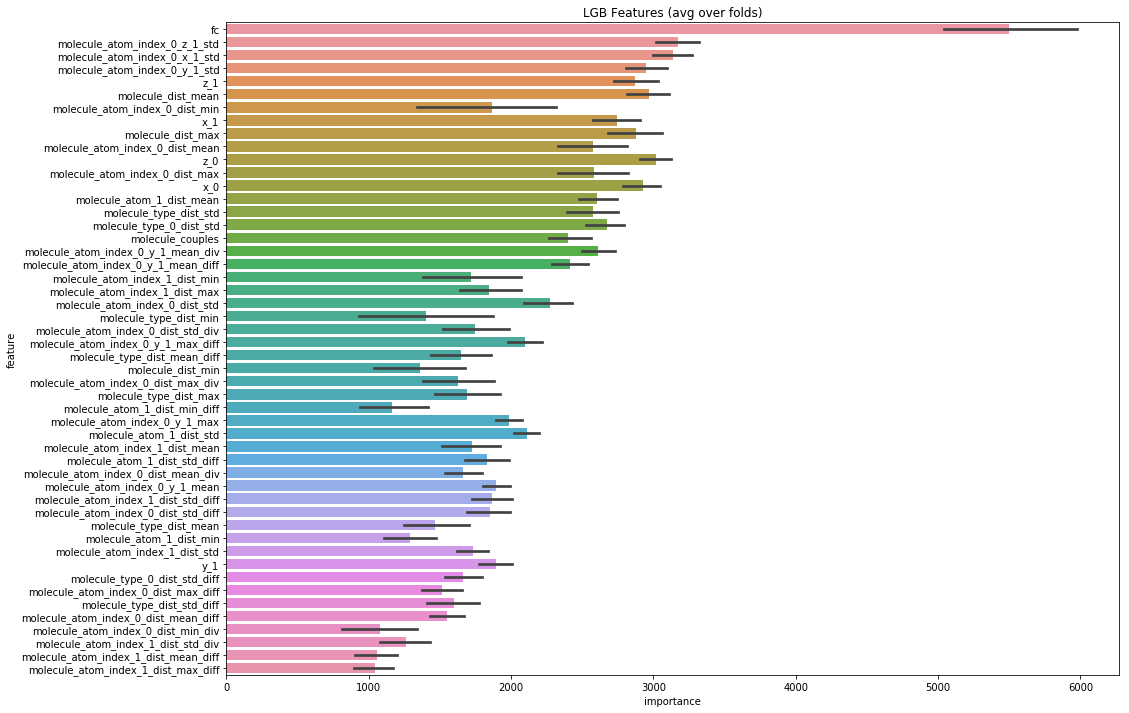

In [36]:
# top 50 features
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

# Save

**submission**

In [37]:
# path_submittion = './output/' + 'nb{}_submission_lgb_{}.csv'.format(nb, metric)
path_submittion = 'nb{}_submission_lgb_{}.csv'.format(nb, metric)
print(f'save pash: {path_submittion}')

save pash: nb23_submission_lgb_-0.5911065383709969.csv


In [38]:
submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')
# submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')[::100]
submittion['scalar_coupling_constant'] = prediction
submittion.to_csv(path_submittion, index=False)

---
**result**

In [39]:
path_oof = './output/' + 'nb{}_oof_lgb_{}.csv'.format(nb, metric)
print(f'save pash: {path_oof}')

save pash: ./output/nb23_oof_lgb_-0.5911065383709969.csv


In [40]:
oof = pd.DataFrame(result_dict['oof'])
oof.to_csv(path_oof, index=False)

# analysis

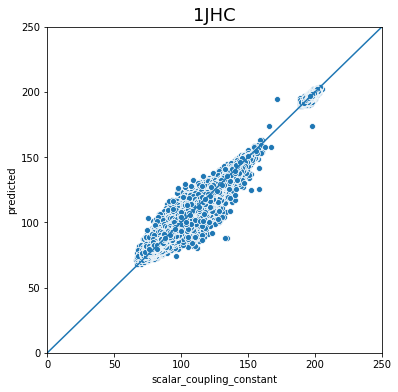

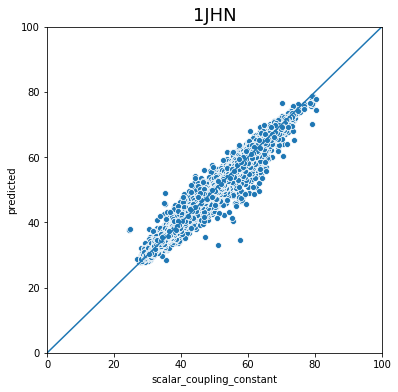

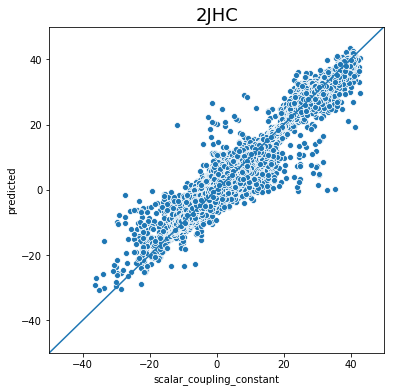

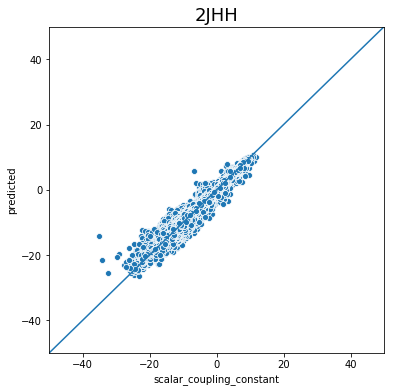

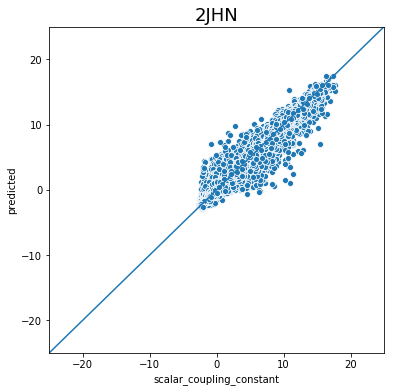

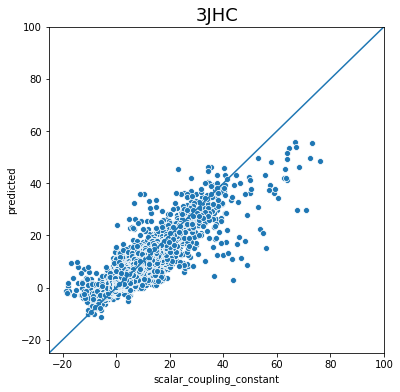

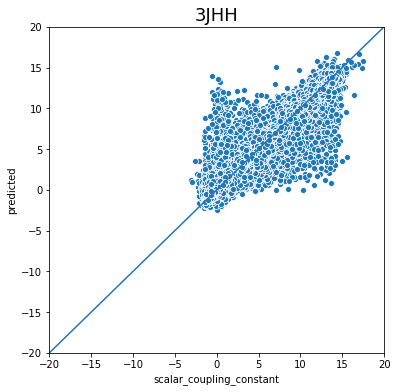

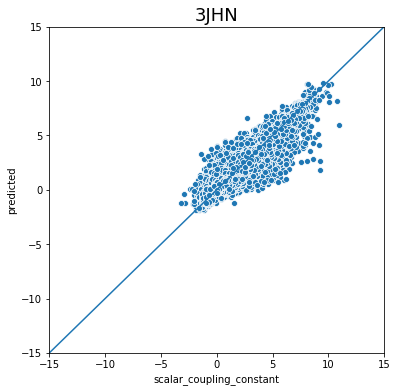

In [41]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = X_short['oof']
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)